In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.sparse import csr_matrix
from scipy.spatial import distance
import os
import warnings; warnings.simplefilter('ignore')
import anndata
import scrublet as scr

import seaborn as sns
sns.set_style('white')

np.random.seed(0)
sc.settings.verbosity = 3 
sc.set_figure_params(scanpy=True, dpi=80)

In [2]:
sc.logging.print_versions()

scanpy==1.4.5 anndata==0.7.5 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
adata = sc.read('veatch_cd4_all20.h5ad')

### 3A

In [4]:
sc.tl.pca(adata, random_state = 1010,svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20, random_state = 1010)
sc.tl.umap(adata, random_state = 1010, min_dist=0.2)
sc.tl.leiden(adata, resolution=1, random_state = 1010)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20


/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:52)


In [5]:
# import manual labels from cellxgene
adata.obs['labels'] = pd.read_csv('data/labels-DJA65MZJ.csv')[2:].values
adata.obs['labels'] = adata.obs['labels'].astype('object')

In [6]:
adata.obs['labels'][adata.obs['labels'] == 'CXCL13_TCF7'] = 'CXCL13+ TCF7+'
adata.obs['labels'][adata.obs['labels'] == 'CXCL13_TCF7-'] = 'CXCL13+ TCF7-'
adata.obs['labels'][adata.obs['labels'] == 'CXCL13_prolif'] = 'Proliferating'
adata.obs['labels'][adata.obs['labels'] == 'FOXP3_prolif'] = 'Proliferating'
adata.obs['labels'][adata.obs['labels'] == 'FOXP3'] = 'FOXP3+ CXCL13-'

In [7]:
sc.set_figure_params(scanpy=True, dpi=80)

... storing 'labels' as categorical
/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:4204: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  (isinstance(c, collections.Iterable) and


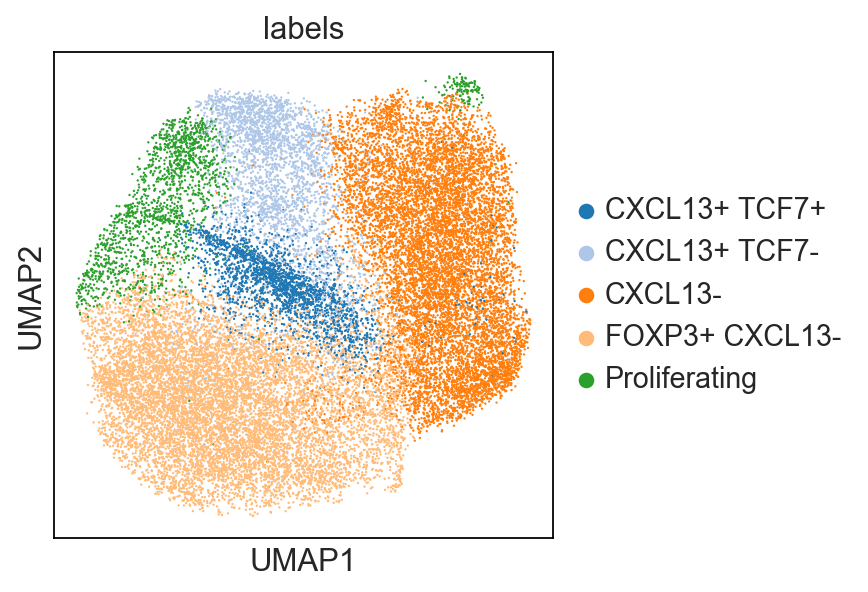

In [8]:
sc.pl.umap(adata, color='labels',
           palette=sns.color_palette("tab20", 20))

### 3B

In [9]:
genes = ['CXCL13','FOXP3','IL7R','TCF7','GZMA','TYMS','IFNG']
ab = ['CD279 (ab)', 'CD39 (ab)','Tim3 (ab)','CD127 (ab)']

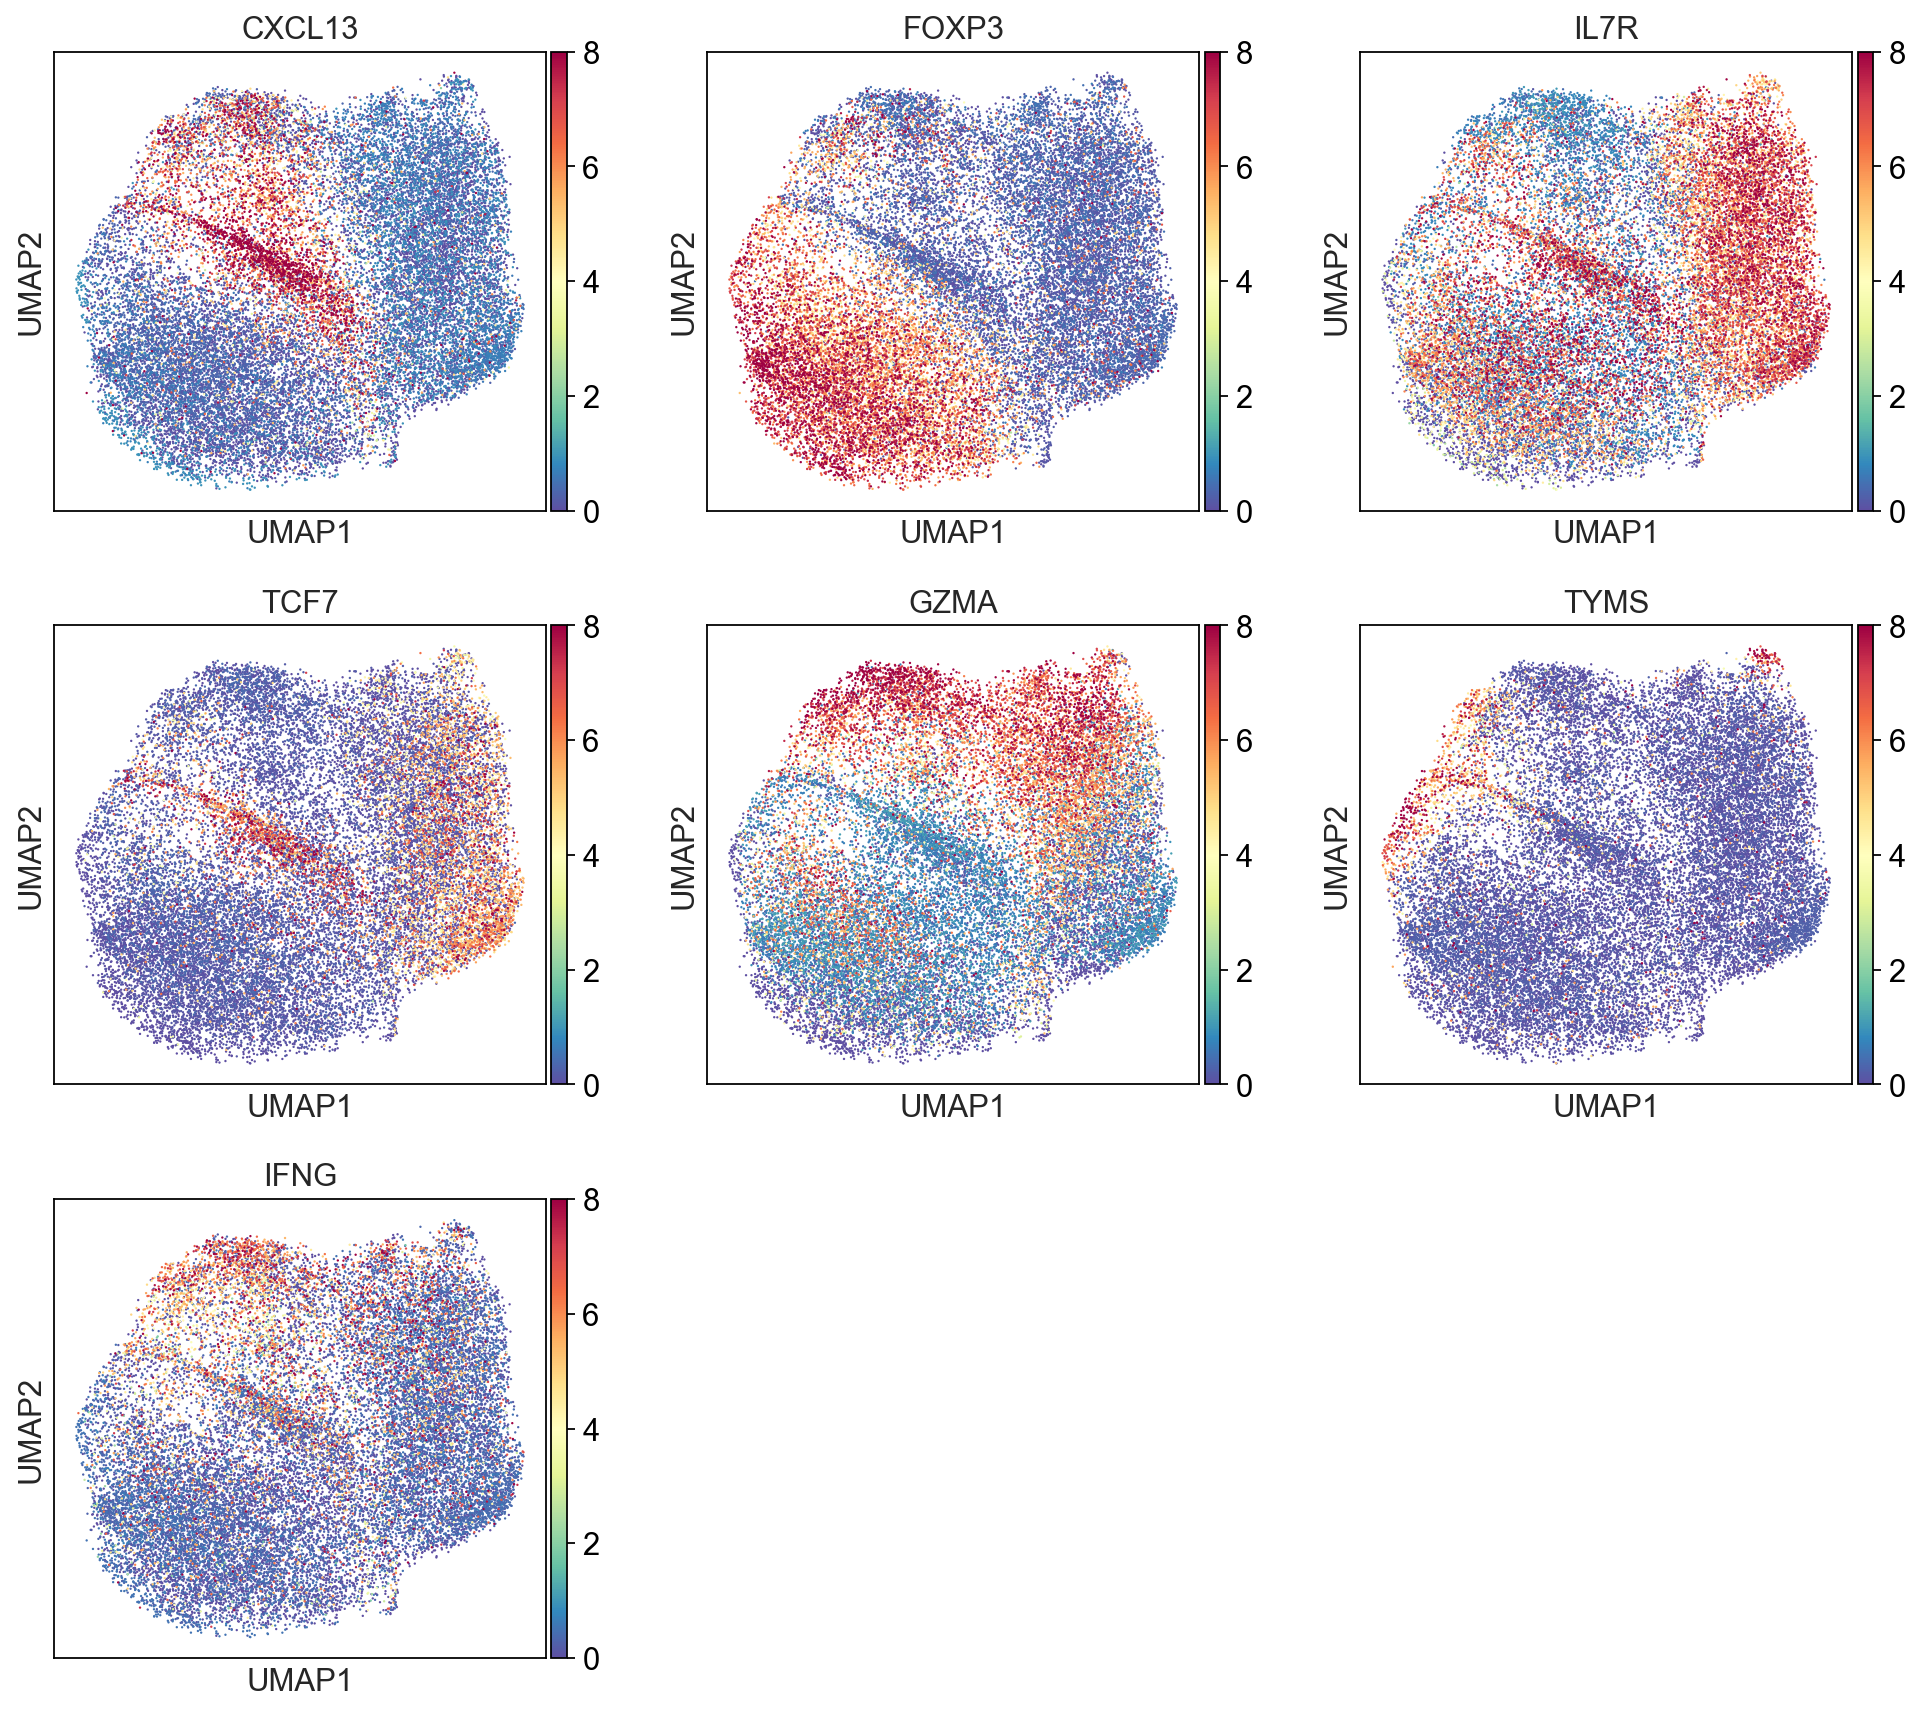

In [10]:
sc.pl.umap(adata, color=genes, ncols=3,vmin=0,vmax=8,
           cmap='Spectral_r')

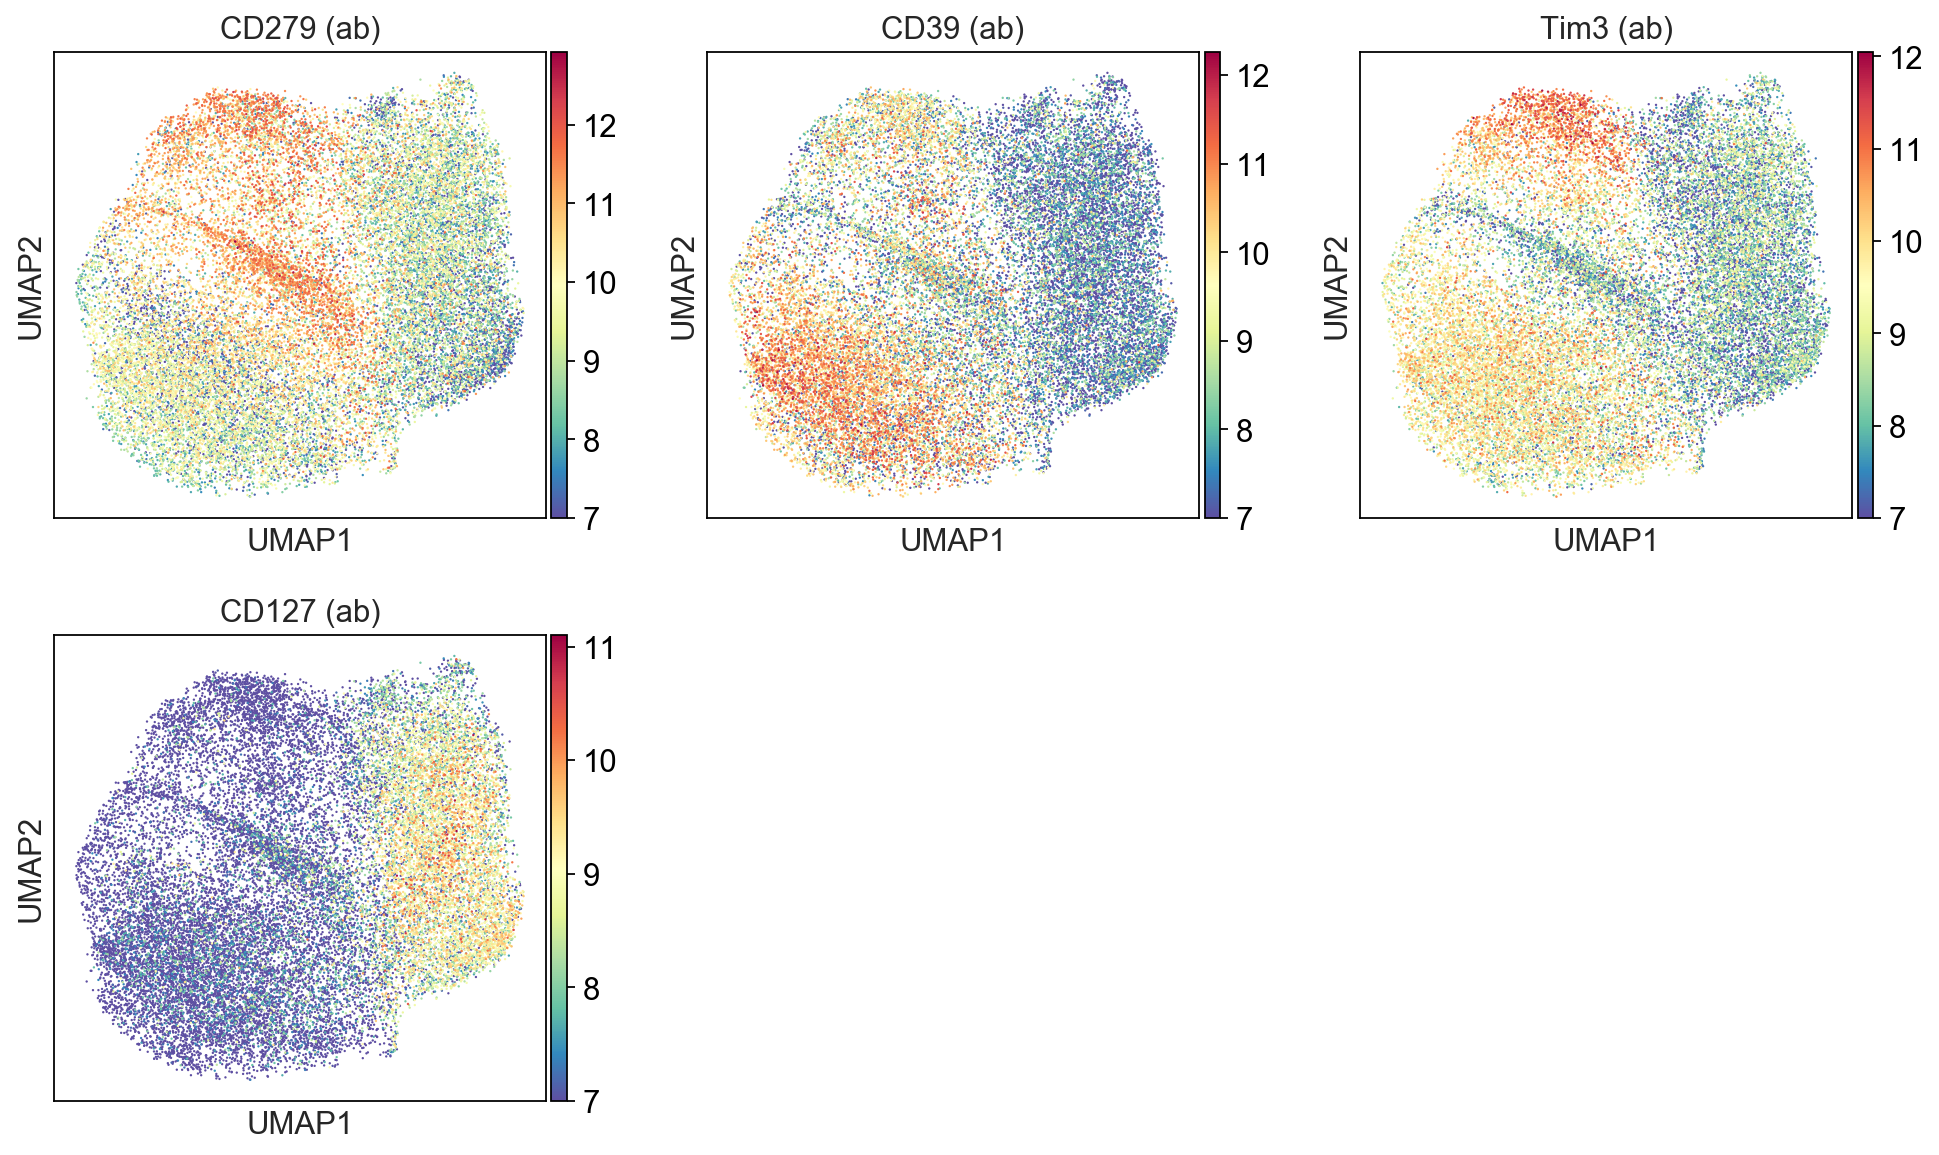

In [11]:
sc.pl.umap(adata, color=ab, ncols=3,vmin=7,
           cmap='Spectral_r')

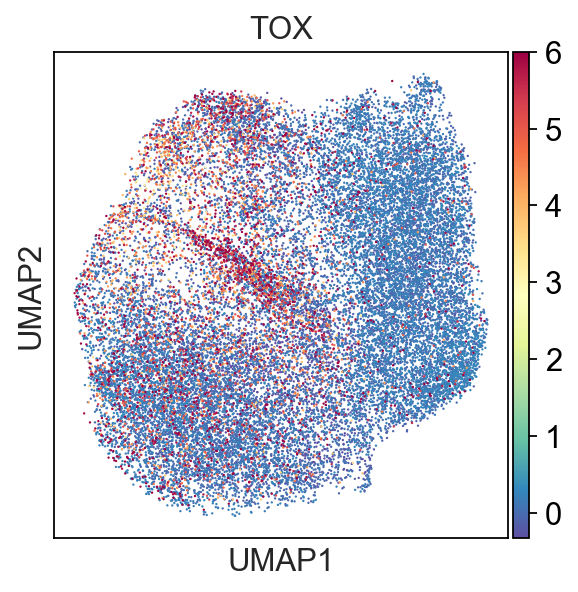

In [12]:
sc.pl.umap(adata, color='TOX', ncols=3,vmax=6,
           cmap='Spectral_r')

### 3C

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_labels']`


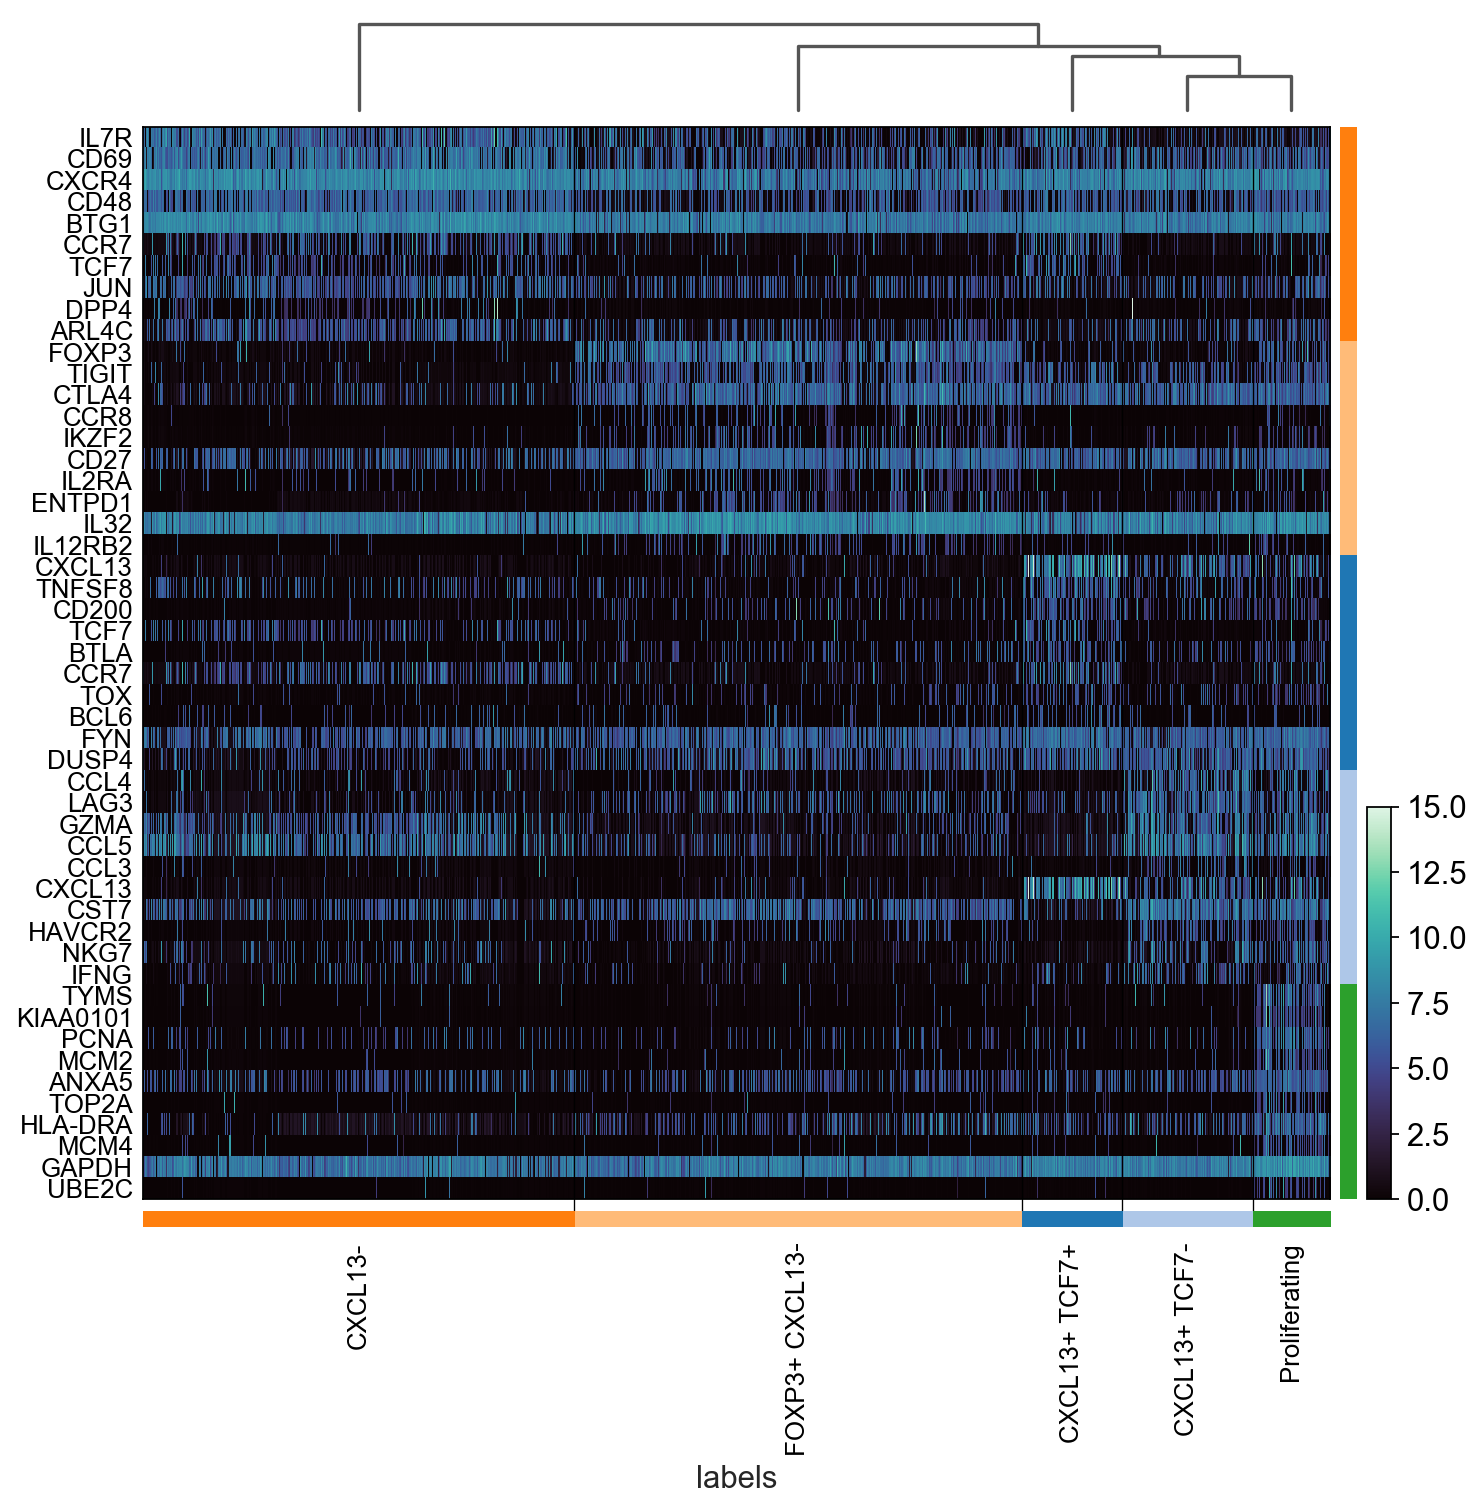

In [13]:
sc.tl.rank_genes_groups(adata, groupby='labels')
sc.pl.rank_genes_groups_heatmap(adata, groupby='labels', n_genes=10,cmap='mako',
                                swap_axes=True,show_gene_labels=True,vmin=0,vmax=15)

### 3F

In [14]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

In [15]:
sns.set_style('white')

In [16]:
# TCGA data imported using TCGAbiolinks
mtx = pd.read_csv('data/TCGA-SKCM_matrix.csv',index_col=0).T
meta = pd.read_csv('data/TCGA-SKCM_meta.csv',index_col=0)
barcode = []
for x in mtx.index:
    barcode.append(x.split('-')[0] + '-' + x.split('-')[1] + '-' + x.split('-')[2])

mtx.index = barcode
col = []
for x in mtx.columns:
    col.append(x.split('|')[0])

mtx.columns = col
meta.index = meta['bcr_patient_barcode']
meta = meta.drop(columns='bcr_patient_barcode')

df = mtx.join(meta, how='inner')
df1 = df[['CXCL13','CD4','vital_status','days_to_death']]
df1['CXCL13/CD4'] = df1['CXCL13']/df1['CD4']

df1['alive'] = 0
df1['alive'][df['vital_status'] == 'Dead'] = 1
df1['survival'] = 99999
df1['survival'][df['vital_status'] == 'Dead'] = df['days_to_death'][df['vital_status'] == 'Dead']
df1['survival'][df1['survival'].isna()] = 10000
df1 = df1[df1['survival'] != 10000]
df1['survival'] = df1['survival']/30

df1 = df1[~df1['CXCL13'].isna()]
df1 = df1[~df1['CD4'].isna()]

df1['CXCL13>med'] = df1['CXCL13'] > np.median(df1['CXCL13'])
df1['CXCL13/CD4>med'] = df1['CXCL13/CD4'] > np.median(df1['CXCL13/CD4'])

cph = CoxPHFitter()

df2 = df1[['CXCL13/CD4>med','alive','survival']]
cph.fit(df2, 'survival', event_col='alive')

results=logrank_test(df1['survival'][df1['CXCL13/CD4'] > np.median(df1['CXCL13/CD4'])],df1['survival'][df1['CXCL13/CD4'] < np.median(df1['CXCL13/CD4'])],event_observed_A=df1['alive'][df1['CXCL13/CD4'] > np.median(df1['CXCL13/CD4'])], event_observed_B=df1['alive'][df1['CXCL13/CD4'] < np.median(df1['CXCL13/CD4'])])

/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:411: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:411: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,


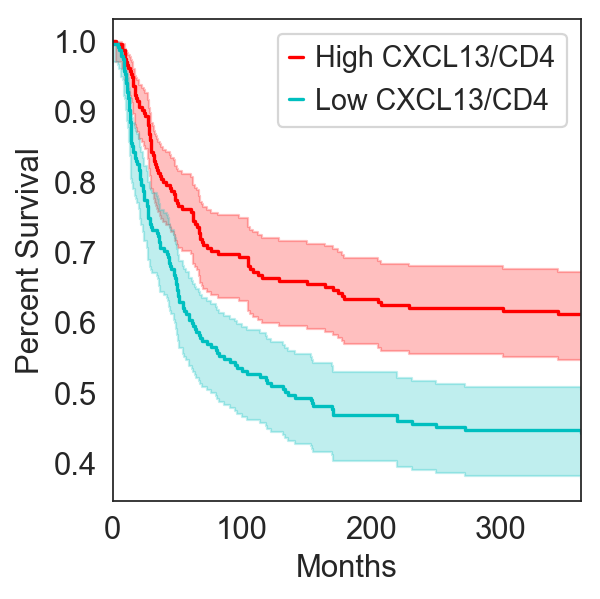

In [17]:
kmf_1 = KaplanMeierFitter()
kmf_1.fit(df1['survival'][df1['CXCL13/CD4'] > np.median(df1['CXCL13/CD4'])], df1['alive'][df1['CXCL13/CD4'] > np.median(df1['CXCL13/CD4'])],label='High CXCL13/CD4')
ax = kmf_1.plot(ci_show=True,color='red')

kmf_2 = KaplanMeierFitter()
kmf_2.fit(df1['survival'][df1['CXCL13/CD4'] < np.median(df1['CXCL13/CD4'])], df1['alive'][df1['CXCL13/CD4'] < np.median(df1['CXCL13/CD4'])],label='Low CXCL13/CD4')
ax = kmf_2.plot(ci_show=True,ax=ax,color='c')
ax.set_ylabel('Percent Survival')
ax.set_xlabel('Months')
ax.set_xlim(0,np.max(df1['days_to_death']/30))

plt.tight_layout()